# Simple MLP regression example


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/rsanchezgarc/AI-ML-analytics-IE/blob/main/notebooks/3_intro_to_DL/simple_mlp_regression.ipynb
)


In [4]:
!pip install joblib torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 36.3 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 25.3 MB/s eta 0:00:00a 0:00:01


In [9]:
import joblib
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [6]:
# 2) Load the data
#    Here we use the diabetes dataset from sklearn, which is already cleaned.
#    In real-life projects, you often need extra steps (e.g., handling missing data,
#    outliers, etc.) before you get to this point.

X, y = load_diabetes(return_X_y=True)
# X is a numpy array of shape (N, num_features)
# y is a numpy array of shape (N,)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

In [12]:
# Scale the features (typical for neural networks)
# This is very important, unscaled features can make your loss function explode
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

os.makedirs("data/diabetes", exist_ok=True)
joblib.dump(scaler, 'data/diabetes/scaler.pkl') #We save the scaler in case we need to use in new data
#Make sure that the path where you are going to save the files do exists

['data/diabetes/scaler.pkl']

In [14]:

# 3) Create a custom Dataset class
#    This makes it straightforward to feed data into a PyTorch model.

class DiabetesDataset(Dataset):
    """PyTorch Dataset for regression.
       Expects X of shape (N, x) and y of shape (N,)."""

    def __init__(self, x, targets=None):
        """
        Args:
            x (numpy.ndarray): Shape (N, x)
            targets (numpy.ndarray, optional): Shape (N,).
                                              If None, we assume inference mode.
        """
        # Convert everything to float32 tensors
        self.x = torch.as_tensor(x, dtype=torch.float32)

        if targets is not None:
            # Convert targets to float32 and add one dimension if needed
            self.targets = torch.as_tensor(targets, dtype=torch.float32).view(-1, 1)
        else:
            self.targets = None

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        """
        This function returns the example number idx
        You can define the input to be whatever you want, in this case is a tuple if
        the dataset has targets
        """
        if self.targets is not None:
            return self.x[idx], self.targets[idx]
        return self.x[idx]

    def input_size(self):
        # Number of features (columns) in X
        return self.x.shape[1]


In [15]:
# 4) Instantiate Dataset objects and DataLoaders

train_dataset = DiabetesDataset(X_train_scaled, y_train)
val_dataset = DiabetesDataset(X_val_scaled, y_val)


def create_dataloader(dataset, batch_size=32):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # set to 0 for debugging; >=1 in bigger projects for speed
        pin_memory=False  # can set to True if using GPU and num_workers>0
    )


train_loader = create_dataloader(train_dataset, batch_size=32)
val_loader = create_dataloader(val_dataset, batch_size=32)


In [16]:
# 5) Define the MLP Model for regression
class DiabetesMLP(nn.Module):
    def __init__(self, input_size):
        super(DiabetesMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)  # Single output for regression
        )

    def forward(self, x):
        return self.layers(x)


In [17]:
# 6) Define training and validation functions

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [18]:
def validate(model, dataloader, criterion, device):
    """Validate on the given dataloader."""
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [19]:
# 7) Training the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = DiabetesMLP(input_size=train_dataset.input_size()).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

n_epochs = 100
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "data/diabetes/model_weights.pt") #To be used when you restart the kernel, use other machine....

Using device: cuda
Epoch [10/100] | Train Loss: 23089.8945 | Val Loss: 20585.8255
Epoch [20/100] | Train Loss: 6451.8082 | Val Loss: 5186.2785
Epoch [30/100] | Train Loss: 4819.9533 | Val Loss: 4116.2004
Epoch [40/100] | Train Loss: 5548.4012 | Val Loss: 3950.8888
Epoch [50/100] | Train Loss: 3700.3810 | Val Loss: 3576.8412
Epoch [60/100] | Train Loss: 3357.1447 | Val Loss: 3467.2733
Epoch [70/100] | Train Loss: 3249.9339 | Val Loss: 3312.8427
Epoch [80/100] | Train Loss: 3463.5966 | Val Loss: 3319.0071
Epoch [90/100] | Train Loss: 3211.9171 | Val Loss: 3159.8095
Epoch [100/100] | Train Loss: 3370.9247 | Val Loss: 3077.2342


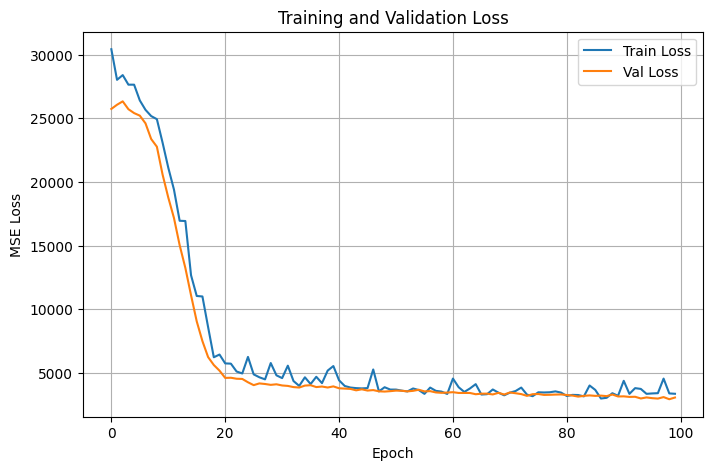

In [20]:
# 8) Plot the training history
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# 9) Evaluate final performance and create scatter plots
#    In real life, you typically have a separate test set,
#    and you might compute additional metrics (like MAE, R^2, etc.)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()

# --- Train set predictions ---
train_preds, train_true = [], []
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).cpu().numpy().flatten()
        train_preds.extend(y_pred)
        train_true.extend(y_batch.numpy().flatten())

train_mse = mean_squared_error(train_true, train_preds)
train_mae = mean_absolute_error(train_true, train_preds)
train_r2 = r2_score(train_true, train_preds)

print("===== Training Performance =====")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R^2: {train_r2:.4f}\n")

# --- Validation set predictions ---
val_preds, val_true = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch).cpu().numpy().flatten()
        val_preds.extend(y_pred)
        val_true.extend(y_batch.numpy().flatten())

val_mse = mean_squared_error(val_true, val_preds)
val_mae = mean_absolute_error(val_true, val_preds)
val_r2 = r2_score(val_true, val_preds)

print("===== Validation Performance =====")
print(f"Val MSE: {val_mse:.4f}")
print(f"Val MAE: {val_mae:.4f}")
print(f"Val R^2: {val_r2:.4f}")

===== Training Performance =====
Train MSE: 2846.9585
Train MAE: 42.4660
Train R^2: 0.5315

===== Validation Performance =====
Val MSE: 3063.5649
Val MAE: 44.2901
Val R^2: 0.4218


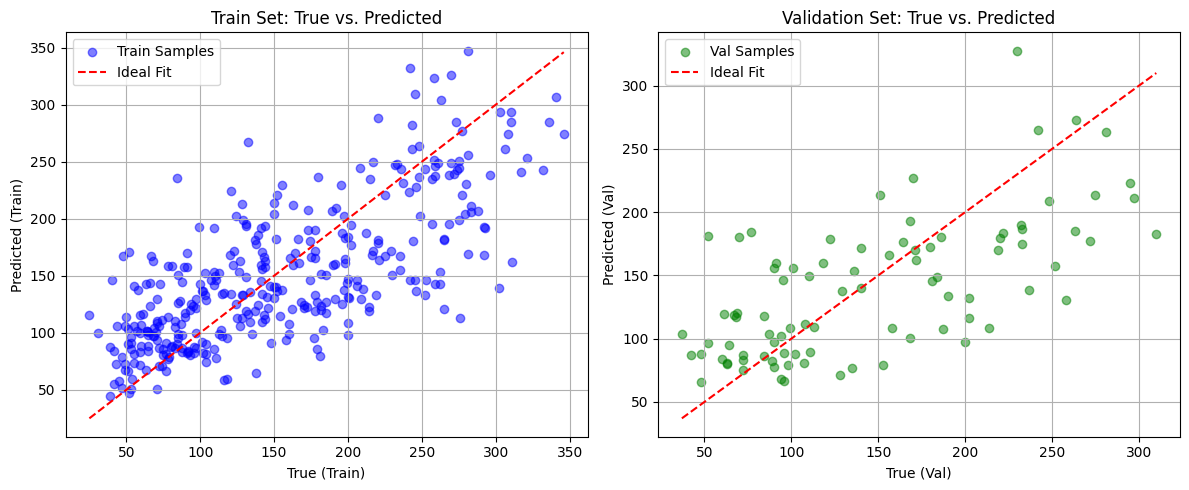

In [22]:
# 10) Plot scatter: Predicted vs. True Values (Train + Val)

plt.figure(figsize=(12, 5))

# Scatter for training data
plt.subplot(1, 2, 1)
plt.scatter(train_true, train_preds, alpha=0.5, color="blue", label="Train Samples")
plt.plot([min(train_true), max(train_true)],
         [min(train_true), max(train_true)],
         color="red", linestyle="--", label="Ideal Fit")
plt.xlabel("True (Train)")
plt.ylabel("Predicted (Train)")
plt.title("Train Set: True vs. Predicted")
plt.legend()
plt.grid(True)

# Scatter for validation data
plt.subplot(1, 2, 2)
plt.scatter(val_true, val_preds, alpha=0.5, color="green", label="Val Samples")
plt.plot([min(val_true), max(val_true)],
         [min(val_true), max(val_true)],
         color="red", linestyle="--", label="Ideal Fit")
plt.xlabel("True (Val)")
plt.ylabel("Predicted (Val)")
plt.title("Validation Set: True vs. Predicted")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Tips:
 - In real-life situations, you usually have to deal with messy data:
   missing values, outliers, categorical data, etc.
 - It's best practice to separate your data into train, validation, and test sets.
 - You often apply transformations like scaling (as shown here), one-hot encoding, etc. Store your scaler or preprocessing pipelines so you can apply the exact same
   transformation to new data or test data.
 - Always keep a separate test set (not used during training or model selection) to get an unbiased estimate of your final performance.
 - Monitor train and validation performance to decide if you are overfitting or underfitting. Make the model more complex or reduce regularization if underfitting. Make the model simpler and increase regularization if overfitting
 - Imbalanced datasets are quite problematic for deep learning. Use class weights in the loss function. Focal loss is quite powerful if doing classification with imbalanced datasets
